# Feature Extractors for Generative Models

```{admonition} Run this webpage in Google Colab using the <i class="fas fa-rocket"></i> icon.
:class: warning
This lecture notes uses packages including pytorch, torchvision. Use Google Colab icon to run the code. Pytorch does not work with live code yet.
```

<div>
<iframe src="https://slides.com/naresh-ub/cvip-lec-13-14/embed" width="100%" height="500" title="Intro to GenAI" scrolling="no" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>
</div>


## 1. Neural Networks as Feature Extractors

A **Neural Network (NN)** can be decomposed into two conceptual parts:

1. **Feature Extractor Module**  
   This maps raw data $ \mathbf{x} \in \mathbb{R}^d $ into a lower-dimensional, informative representation $ \mathbf{z} $.  

   $$
   \mathbf{z} = f_{\theta}(\mathbf{x})
   $$

   where $ f_{\theta} $ represents the layers (e.g., convolutions, activations, pooling) that distill relevant features.

2. **Task-Specific Head**  
   A shallow network operating on $ \mathbf{z} $, tailored for the task at hand (e.g., classification, regression).  

   $$
   \hat{y} = g_{\phi}(\mathbf{z})
   $$

   Overall, the network becomes:

   $$
   \hat{y} = g_{\phi}(f_{\theta}(\mathbf{x}))
   $$

The feature extractor compresses and organizes raw data into representations where *similar inputs are close in feature space*.  

---

## 2. Feature Space and Low-Dimensional Manifolds

Consider images $ \mathbf{x}_i $ and $ \mathbf{x}_j $. If they are "closer" in visual content, their **feature representations** $ f_{\theta}(\mathbf{x}_i) $ and $ f_{\theta}(\mathbf{x}_j) $ will lie close in the learned low-dimensional manifold.  

This property enables **clustering, visualization, and transfer learning**.

> The code below shows how NNs that are trained for classification tasks can inherently perform feature representation in the low-dimensional space.

Using device: cpu
Epoch [1/10], Loss: 0.7174
Epoch [2/10], Loss: 0.3166
Epoch [3/10], Loss: 0.2268
Epoch [4/10], Loss: 0.1734
Epoch [5/10], Loss: 0.1394
Epoch [6/10], Loss: 0.1189
Epoch [7/10], Loss: 0.0930
Epoch [8/10], Loss: 0.0866
Epoch [9/10], Loss: 0.0793
Epoch [10/10], Loss: 0.0690


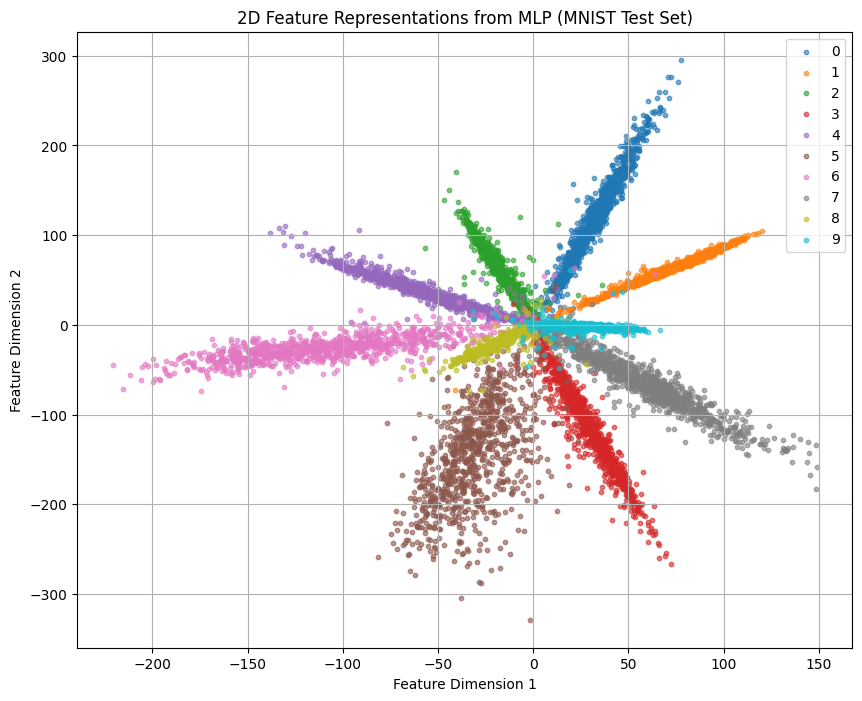

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

# 2. Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.feature_layer = nn.Linear(128, 2)  # 2D features
        self.classifier = nn.Linear(2, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        features = self.feature_layer(x)
        out = self.classifier(features)
        return out, features

model = MLP().to(device)

# 3. Training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train(model, loader):
    model.train()
    for epoch in range(10):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss / len(loader):.4f}")

train(model, train_loader)

# 4. Extract 2D features from test set
def extract_features(model, loader):
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            _, features = model(images)
            all_features.append(features.cpu())
            all_labels.append(labels)

    return torch.cat(all_features, dim=0), torch.cat(all_labels, dim=0)

features, labels = extract_features(model, test_loader)

# 5. Scatter plot
def plot_features(features, labels):
    features = features.numpy()
    labels = labels.numpy()
    plt.figure(figsize=(10, 8))
    for digit in range(10):
        idxs = labels == digit
        plt.scatter(features[idxs, 0], features[idxs, 1], label=str(digit), alpha=0.6, s=10)

    plt.legend()
    plt.title("2D Feature Representations from MLP (MNIST Test Set)")
    plt.xlabel("Feature Dimension 1")
    plt.ylabel("Feature Dimension 2")
    plt.grid(True)
    plt.show()

plot_features(features, labels)

> In the case of Convolutional Neural Networks (CNNs) too, we see similar feature representation coming into the picture. The code below trains a simple CNN model for classification and the corresponding feature extraction is visualized.

Using device: cpu
Epoch [1/10], Loss: 0.6608
Epoch [2/10], Loss: 0.2055
Epoch [3/10], Loss: 0.1303
Epoch [4/10], Loss: 0.0939
Epoch [5/10], Loss: 0.0741
Epoch [6/10], Loss: 0.0593
Epoch [7/10], Loss: 0.0480
Epoch [8/10], Loss: 0.0382
Epoch [9/10], Loss: 0.0327
Epoch [10/10], Loss: 0.0284


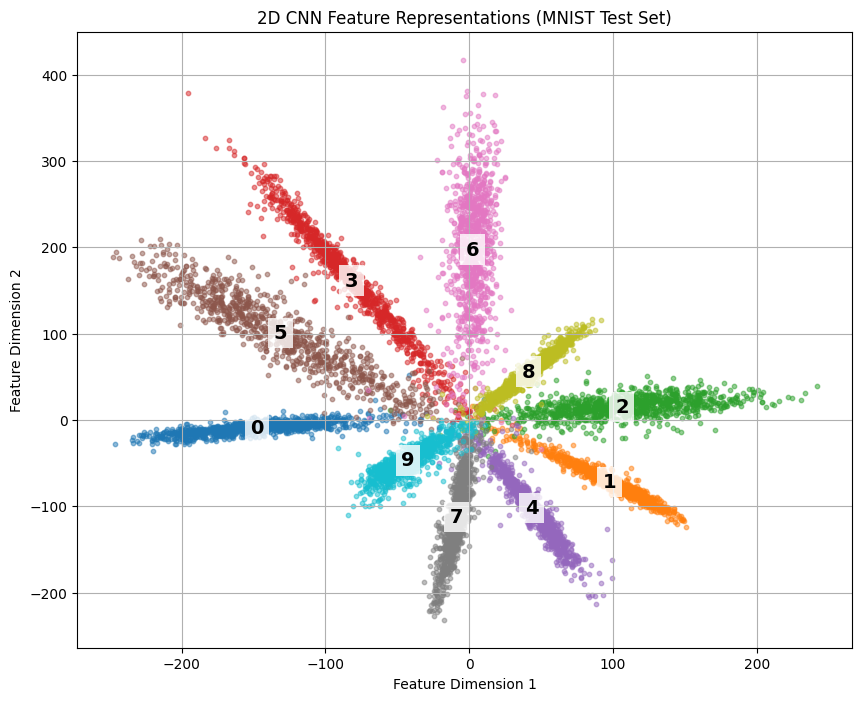

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset and loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.feature_layer = nn.Linear(128, 2)
        self.classifier = nn.Linear(2, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # [B, 32, 14, 14]
        x = self.pool2(F.relu(self.conv2(x)))  # [B, 64, 7, 7]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        features = self.feature_layer(x)
        out = self.classifier(features)
        return out, features

model = CNN().to(device)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Training loop
def train(model, loader):
    model.train()
    for epoch in range(10):
        total_loss = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss / len(loader):.4f}")

train(model, train_loader)

# Extract 2D features
def extract_features(model, loader):
    model.eval()
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            _, features = model(images)
            all_features.append(features.cpu())
            all_labels.append(labels)

    return torch.cat(all_features, dim=0), torch.cat(all_labels, dim=0)

features, labels = extract_features(model, test_loader)

# Scatter plot with cluster centers labeled
def plot_features(features, labels):
    features = features.numpy()
    labels = labels.numpy()
    plt.figure(figsize=(10, 8))

    for digit in range(10):
        idxs = labels == digit
        x_vals = features[idxs, 0]
        y_vals = features[idxs, 1]
        plt.scatter(x_vals, y_vals, label=str(digit), alpha=0.5, s=10)

        # Cluster center
        center_x = np.mean(x_vals)
        center_y = np.mean(y_vals)
        plt.text(center_x, center_y, str(digit), fontsize=14, weight='bold',
                 ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    plt.title("2D CNN Feature Representations (MNIST Test Set)")
    plt.xlabel("Feature Dimension 1")
    plt.ylabel("Feature Dimension 2")
    plt.grid(True)
    plt.show()

plot_features(features, labels)

This good feature representation naturally results in the creation of AutoEncoders (which are simply encoder-decoder blocks).

## 3. Autoencoders (AEs)

An **Autoencoder** is a special neural network trained to reconstruct its input.  
It consists of two main parts:

1. **Encoder**: maps input $ \mathbf{x} $ to a latent code $ \mathbf{z} $. 
    
   $$
   \mathbf{z} = f_{\theta}(\mathbf{x})
   $$

2. **Decoder**: reconstructs the input from the latent code.
     
   $$
   \hat{\mathbf{x}} = g_{\phi}(\mathbf{z})
   $$

The **objective function** is to minimize reconstruction error, often via Mean Squared Error (MSE):

$$
\mathcal{L}_{\text{AE}}(\theta, \phi) = \frac{1}{N}\sum_{i=1}^{N} \lVert \mathbf{x}_i - g_{\phi}(f_{\theta}(\mathbf{x}_i)) \rVert^2
$$

### 3.1 Simple MLP Autoencoder
- Encoder and decoder implemented as fully connected layers.
- Latent space dimension is much smaller than input → forces **dimensionality reduction**.

### 3.2 Convolutional Autoencoder
- Uses convolutional layers for images.
- Encoder progressively downsamples, decoder uses **transpose convolutions** (a.k.a. deconvolutions) to reconstruct.

Using device: cpu
Epoch [1/10], Loss: 0.7178
Epoch [2/10], Loss: 0.6644
Epoch [3/10], Loss: 0.6491
Epoch [4/10], Loss: 0.6420
Epoch [5/10], Loss: 0.6374
Epoch [6/10], Loss: 0.6344
Epoch [7/10], Loss: 0.6319
Epoch [8/10], Loss: 0.6298
Epoch [9/10], Loss: 0.6280
Epoch [10/10], Loss: 0.6266


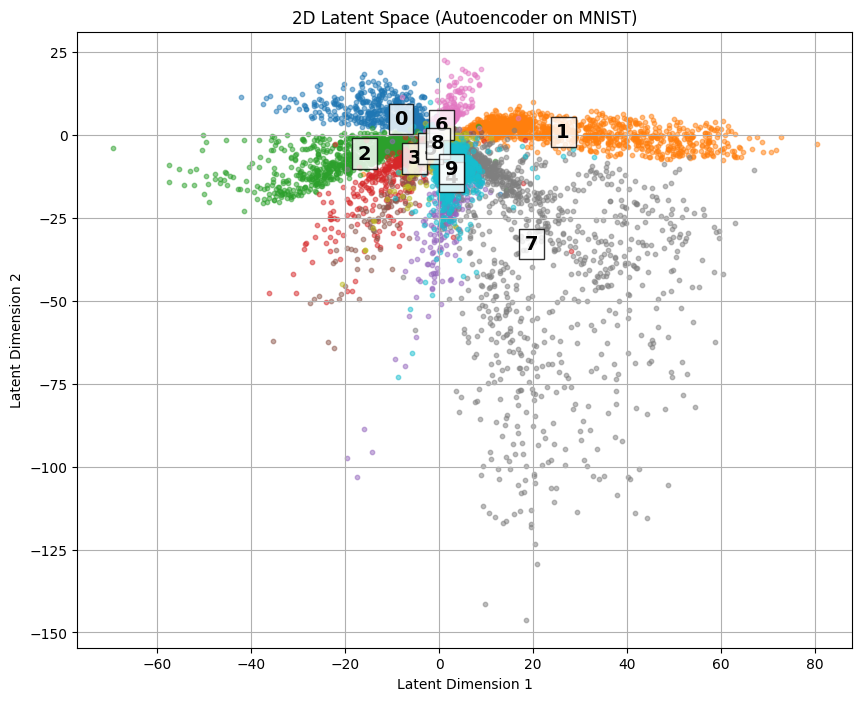

In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # [B, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [B, 64, 7, 7]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # 2D latent vector
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [B, 32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),   # [B, 1, 28, 28]
            nn.Sigmoid()  # For grayscale pixel values between 0 and 1
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop
def train(model, loader):
    model.train()
    for epoch in range(10):
        total_loss = 0
        for images, _ in loader:
            images = images.to(device)

            optimizer.zero_grad()
            recon, _ = model(images)

            # Reconstruction loss: How close is the decoded image to the original?
            loss = criterion(recon, images)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss / len(loader):.4f}")

train(autoencoder, train_loader)

# Extract latent features for visualization
def extract_latents(model, loader):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for images, label in loader:
            images = images.to(device)
            _, z = model(images)
            latents.append(z.cpu())
            labels.append(label)
    return torch.cat(latents), torch.cat(labels)

features, labels = extract_latents(autoencoder, test_loader)

# Plot latent space with digit labels at cluster centers
def plot_latents(features, labels):
    features = features.numpy()
    labels = labels.numpy()
    plt.figure(figsize=(10, 8))
    for digit in range(10):
        idxs = labels == digit
        x_vals = features[idxs, 0]
        y_vals = features[idxs, 1]
        plt.scatter(x_vals, y_vals, label=str(digit), alpha=0.5, s=10)

        center_x = np.mean(x_vals)
        center_y = np.mean(y_vals)
        plt.text(center_x, center_y, str(digit), fontsize=14, weight='bold',
                 ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.8))

    plt.title("2D Latent Space (Autoencoder on MNIST)")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True)
    plt.show()

plot_latents(features, labels)

As the autoencoder above reduces the features to **two dimensions**, we can easily visualize the features. The plot above provides us with a convenient way to generate images from 2D features.

> Below is a simple reconstruction code to generate new images based on the feature representation by the encoder model.

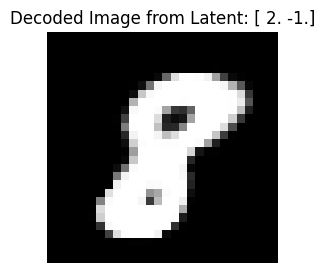

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set this to your desired 2D latent vector (example: center of a cluster)
custom_latent = np.array([2.0, -1.0], dtype=np.float32)

# Convert to tensor
z = torch.tensor(custom_latent).unsqueeze(0).to(device)  # shape [1, 2]

# Decode
autoencoder.eval()
with torch.no_grad():
    decoded_img = autoencoder.decoder(z).cpu().squeeze().numpy()

# Plot image
plt.figure(figsize=(3, 3))
plt.imshow(decoded_img, cmap='gray')
plt.title(f"Decoded Image from Latent: {custom_latent}")
plt.axis('off')
plt.show()

## 4. Limitations of Standard Autoencoders
- They learn a **deterministic mapping** $ \mathbf{x} \mapsto \mathbf{z} $.
- Latent codes may not follow any structured distribution.
- Difficult to use them directly as **generative models**.

This motivates **Variational Autoencoders**.

## 5. Variational Autoencoders (VAEs)

### 5.1 Generative Modeling

We assume data $ \mathbf{x} $ is generated from latent variables $ \mathbf{z} $ via:

$$
p_{\theta}(\mathbf{x}, \mathbf{z}) = p_{\theta}(\mathbf{x} \mid \mathbf{z}) \, p(\mathbf{z})
$$

- **Prior**: $ p(\mathbf{z}) $ (usually $ \mathcal{N}(0, I) $)  
- **Likelihood**: $ p_{\theta}(\mathbf{x} \mid \mathbf{z}) $ defined by the decoder.

The posterior is:

$$
p_{\theta}(\mathbf{z} \mid \mathbf{x}) = \frac{p_{\theta}(\mathbf{x} \mid \mathbf{z}) \, p(\mathbf{z})}{p_{\theta}(\mathbf{x})}
$$

But computing $ p_{\theta}(\mathbf{x}) = \int p_{\theta}(\mathbf{x} \mid \mathbf{z}) p(\mathbf{z}) \, d\mathbf{z} $ is intractable.

---

### 5.2 Variational Inference

Introduce an **approximate posterior** $ q_{\phi}(\mathbf{z} \mid \mathbf{x}) $ (the encoder).  

We optimize the **Evidence Lower Bound (ELBO):**

$$
\log p_{\theta}(\mathbf{x}) \geq \mathbb{E}_{q_{\phi}(\mathbf{z}\mid\mathbf{x})}\big[ \log p_{\theta}(\mathbf{x}\mid \mathbf{z}) \big] - \text{KL}\!\left( q_{\phi}(\mathbf{z}\mid \mathbf{x}) \; \| \; p(\mathbf{z}) \right)
$$

- First term: reconstruction likelihood (forces decoder to explain input).  
- Second term: KL divergence (regularizes latent space to match prior).  

Thus, the **VAE loss function** is:

$$
\mathcal{L}_{\text{VAE}}(\theta, \phi; \mathbf{x}) = - \mathbb{E}_{q_{\phi}(\mathbf{z}\mid\mathbf{x})} \big[ \log p_{\theta}(\mathbf{x}\mid \mathbf{z}) \big] + \text{KL}\!\left( q_{\phi}(\mathbf{z}\mid \mathbf{x}) \; \| \; p(\mathbf{z}) \right)
$$

---

### 5.3 Reparameterization Trick

To backpropagate through stochastic sampling, we reparameterize:

$$
\mathbf{z} \sim q_{\phi}(\mathbf{z} \mid \mathbf{x}) = \mathcal{N}(\mu_{\phi}(\mathbf{x}), \, \sigma^2_{\phi}(\mathbf{x})I)
$$

Instead of sampling directly, we write:

$$
\mathbf{z} = \mu_{\phi}(\mathbf{x}) + \sigma_{\phi}(\mathbf{x}) \odot \boldsymbol{\epsilon}, \quad \boldsymbol{\epsilon} \sim \mathcal{N}(0, I)
$$

This makes $ \mathbf{z} $ a **deterministic function** of $ \mathbf{x} $ and noise $ \boldsymbol{\epsilon} $, allowing gradients to flow.

---

## 6. Inference with AEs and VAEs

- **Autoencoder**:  
  Encode → get compressed representation.  
  Decode → reconstruct input.

- **VAE**:  
  Encode → obtain distribution parameters $ (\mu, \sigma) $.  
  Sample $ \mathbf{z} $ → Decode → generate **stochastic reconstructions**.  
  Can also sample $ \mathbf{z} \sim \mathcal{N}(0,I) $ directly → **new data generation**.

Using device: cuda
Epoch [1/10], Loss: 591.1454
Epoch [2/10], Loss: 541.8582
Epoch [3/10], Loss: 533.9161
Epoch [4/10], Loss: 530.0660
Epoch [5/10], Loss: 527.4918
Epoch [6/10], Loss: 525.5694
Epoch [7/10], Loss: 523.7681
Epoch [8/10], Loss: 522.1676
Epoch [9/10], Loss: 520.7486
Epoch [10/10], Loss: 519.5998


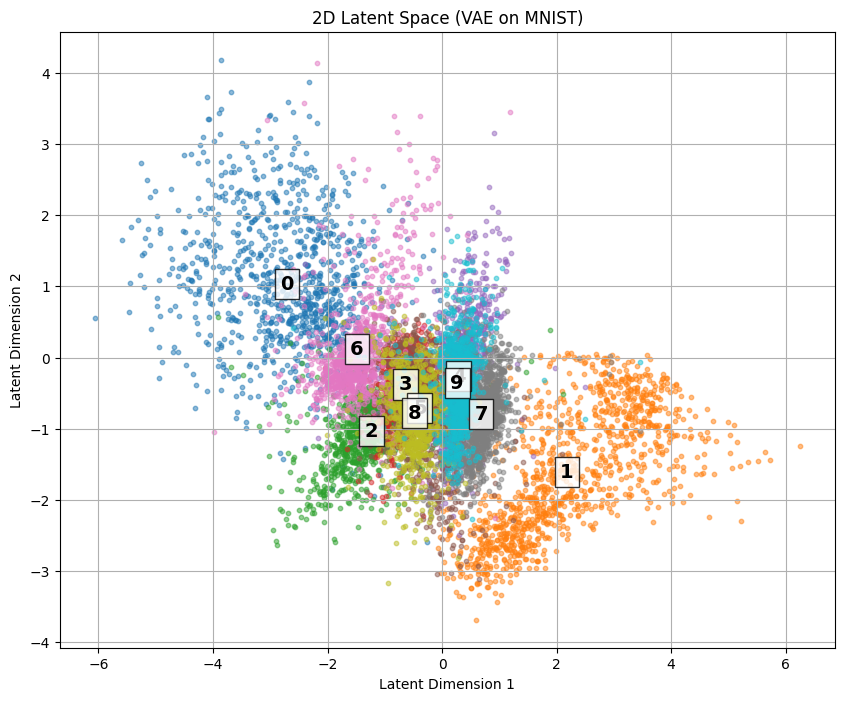

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=256, shuffle=False)

# VAE Model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # [B, 32, 14, 14]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # [B, 64, 7, 7]
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, 2)
        self.fc_logvar = nn.Linear(64 * 7 * 7, 2)

        # Decoder
        self.decoder_input = nn.Linear(2, 64 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # [B, 32, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),   # [B, 1, 28, 28]
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        out = self.decode(z)
        return out, mu, logvar, z

vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# VAE Loss = Reconstruction + KL Divergence
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # Pixel-wise loss
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL term
    return recon_loss + kl_div

# Training loop
def train(model, loader):
    model.train()
    for epoch in range(10):
        total_loss = 0
        for images, _ in loader:
            images = images.to(device)
            optimizer.zero_grad()

            recon, mu, logvar, _ = model(images)

            # Loss = reconstruction + KL divergence
            loss = loss_function(recon, images, mu, logvar)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/10], Loss: {total_loss / len(loader.dataset):.4f}")

train(vae, train_loader)

# Visualize latent space
def extract_latents(model, loader):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for images, label in loader:
            images = images.to(device)
            _, _, _, z = model(images)
            latents.append(z.cpu())
            labels.append(label)
    return torch.cat(latents), torch.cat(labels)

features, labels = extract_latents(vae, test_loader)

def plot_latents(features, labels):
    features = features.numpy()
    labels = labels.numpy()
    plt.figure(figsize=(10, 8))
    for digit in range(10):
        idxs = labels == digit
        x_vals = features[idxs, 0]
        y_vals = features[idxs, 1]
        plt.scatter(x_vals, y_vals, label=str(digit), alpha=0.5, s=10)

        center_x = np.mean(x_vals)
        center_y = np.mean(y_vals)
        plt.text(center_x, center_y, str(digit), fontsize=14, weight='bold',
                 ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.8))

    plt.title("2D Latent Space (VAE on MNIST)")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.grid(True)
    plt.show()

plot_latents(features, labels)

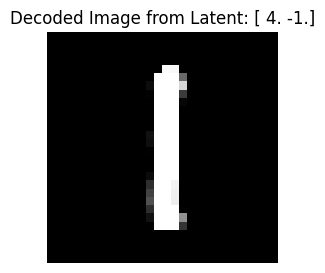

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Example latent point (explore from -4 to 4)
custom_latent = np.array([4.0, -1.0], dtype=np.float32)

# Convert to tensor
z = torch.tensor(custom_latent).unsqueeze(0).to(device)

# Decode to image
vae.eval()
with torch.no_grad():
    decoded_img = vae.decode(z).cpu().squeeze().numpy()

# Plot the decoded image
plt.figure(figsize=(3, 3))
plt.imshow(decoded_img, cmap='gray')
plt.title(f"Decoded Image from Latent: {custom_latent}")
plt.axis('off')
plt.show()

## 7. Summary

- Neural networks are natural **feature extractors**.  
- Autoencoders compress input into a lower-dimensional **latent representation** and reconstruct.  
- VAEs extend this idea with **probabilistic latent variables**, enabling **generative modeling**.  
- The **ELBO objective** balances reconstruction quality and latent space regularity.  
- The **reparameterization trick** is key for training VAEs.